### Aim: DILI class modeling and labels/predictions on >2300 drugs

In this notebook, 913/1036 FDA approved pharmaceutical drugs are modeled for being "mostDILI" (highest risk level) vs "otherDILI" (all other DILI classes combined into one). 

Subsequently, this model is used to generate DILI risk predictions on 1294 additional FDA approved drugs that are currently not annotated for their DILI risk.

Data for modeling contains relative proportions of each adverse drug reaction (ADR) category for 913 drugs and their DILI risk labels ("most-DILI-Concern" vs "other-DILI-Concern").  Modeling/DILI risk predictions will be done using following steps:

    A. Generate a baseline model using features processed with/without transformation (untransformed vs Z-transformation vs log2 transformation to be compared). Choose feature processing option with best performance on baseline model. 
    - Logistic regression will be chosen for baseline model and based on performance relative to a benchmark model(logistic regression published in Chen M et  al., 2016 Hepatology), other algorithms may not be evaluated.

    B. Exploratory data analysis - distribution analysis and correlation plots on feature transformations.

    C. "Feature selection" from baseline model for "final" model development

    D. Generate predictions for ~1300 DILI risk unlabeled drugs using "final" model. 


Export all predicted DILI risk labels for combining with drugs with existing DILI risk labels.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn') 

import seaborn as sns

import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\pandas_profiling\plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Sri Bandhakavi\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 563, 

In [2]:
#magic command to print all output instead of only last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**1. Import dataset and process for feature transformations (none, Z-transform, log2 transform) of numeric columns**

Effect of feature transformations on EDA and model performance will be evaluated.

In [3]:
rwe_xy=pd.read_csv("rwe_dili_modeling_df.csv")

In [4]:
rwe_xy.head()

,drug,Blood and lymphatic system disorders,Cardiac disorders,"Congenital, familial and genetic disorders",Ear and labyrinth disorders,Endocrine disorders,Eye disorders,Gastrointestinal disorders,General disorders and administration site conditions,Hepatobiliary disorders,...,Renal and urinary disorders,Reproductive system and breast disorders,"Respiratory, thoracic and mediastinal disorders",Skin and subcutaneous tissue disorders,Social circumstances,Surgical and medical procedures,Vascular disorders,DILIConcern,vDILIConcern,SMILES
0,4-aminosalicylic acid,0.028032,0.006865,0.001144,0.018021,0.016876,0.008867,0.382437,0.102403,0.032895,...,0.010584,0.000286,0.023455,0.097540,0.001144,0.000572,0.005721,Most-DILI-Concern,vMost-DILI-Concern,C1=CC(=C(C=C1N)O)C(=O)O
1,Argipressin,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,...,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.153846,No-DILI-Concern,vNo-DILI-Concern,C1CC(N(C1)C(=O)C2CSSCC(C(=O)NC(C(=O)NC(C(=O)NC...
2,Hetastarch,0.048276,0.055603,0.000000,0.000862,0.000000,0.003448,0.059914,0.089655,0.008621,...,0.041810,0.003017,0.088793,0.209483,0.000000,0.000000,0.113793,No-DILI-Concern,vNo-DILI-Concern,NaN
3,Levoleucovorin,0.090259,0.023458,0.001340,0.002904,0.000223,0.007819,0.145666,0.092940,0.012288,...,0.015192,0.001117,0.089366,0.100313,0.000000,0.001340,0.045353,No-DILI-Concern,vNo-DILI-Concern,C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C...
4,abacavir,0.027546,0.024868,0.010177,0.004285,0.001913,0.008646,0.112786,0.150126,0.026934,...,0.025480,0.007499,0.043615,0.142628,0.001148,0.005356,0.016145,Most-DILI-Concern,vMost-DILI-Concern,C1CC1NC2=NC(=NC3=C2N=CN3C4C[C@H](C=C4)CO)N


All 27 adverse drug reactions are shown as relative % for each drug indicated by name in first column; the ADR proportions will be used as the "predictor" (X) matrix for modeling. Outcome (Y) of interest is contained within the "DILIConcern" column.  The two additional columns: vDILI Concern (alternative DILI concern label) and SMILES (1D-structural representation of molecule) will not be used for modeling purposes.

**1.1: X matrix without transformation**

In [5]:
rwe_numerics=[ 'Blood and lymphatic system disorders','Cardiac disorders','Congenital, familial and genetic disorders',
              'Ear and labyrinth disorders','Endocrine disorders','Eye disorders','Gastrointestinal disorders',
              'General disorders and administration site conditions','Hepatobiliary disorders','Immune system disorders',
              'Infections and infestations','Injury, poisoning and procedural complications','Investigations',
              'Metabolism and nutrition disorders','Musculoskeletal and connective tissue disorders',
              'Neoplasms benign, malignant and unspecified (incl cysts and polyps)','Nervous system disorders',
              'Pregnancy, puerperium and perinatal conditions','Product issues','Psychiatric disorders',
              'Renal and urinary disorders','Reproductive system and breast disorders',
              'Respiratory, thoracic and mediastinal disorders','Skin and subcutaneous tissue disorders',
              'Social circumstances','Surgical and medical procedures','Vascular disorders']

x=rwe_xy[rwe_numerics]

In [6]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 27 columns):
Blood and lymphatic system disorders                                   913 non-null float64
Cardiac disorders                                                      913 non-null float64
Congenital, familial and genetic disorders                             913 non-null float64
Ear and labyrinth disorders                                            913 non-null float64
Endocrine disorders                                                    913 non-null float64
Eye disorders                                                          913 non-null float64
Gastrointestinal disorders                                             913 non-null float64
General disorders and administration site conditions                   913 non-null float64
Hepatobiliary disorders                                                913 non-null float64
Immune system disorders                                            

In [7]:
x.head()

,Blood and lymphatic system disorders,Cardiac disorders,"Congenital, familial and genetic disorders",Ear and labyrinth disorders,Endocrine disorders,Eye disorders,Gastrointestinal disorders,General disorders and administration site conditions,Hepatobiliary disorders,Immune system disorders,...,"Pregnancy, puerperium and perinatal conditions",Product issues,Psychiatric disorders,Renal and urinary disorders,Reproductive system and breast disorders,"Respiratory, thoracic and mediastinal disorders",Skin and subcutaneous tissue disorders,Social circumstances,Surgical and medical procedures,Vascular disorders
0,0.028032,0.006865,0.001144,0.018021,0.016876,0.008867,0.382437,0.102403,0.032895,0.005435,...,0.002002,0.000000,0.028604,0.010584,0.000286,0.023455,0.097540,0.001144,0.000572,0.005721
1,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.000000,...,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.153846
2,0.048276,0.055603,0.000000,0.000862,0.000000,0.003448,0.059914,0.089655,0.008621,0.088362,...,0.001724,0.000862,0.007759,0.041810,0.003017,0.088793,0.209483,0.000000,0.000000,0.113793
3,0.090259,0.023458,0.001340,0.002904,0.000223,0.007819,0.145666,0.092940,0.012288,0.046470,...,0.000447,0.000223,0.004468,0.015192,0.001117,0.089366,0.100313,0.000000,0.001340,0.045353
4,0.027546,0.024868,0.010177,0.004285,0.001913,0.008646,0.112786,0.150126,0.026934,0.063509,...,0.013620,0.000995,0.025480,0.025480,0.007499,0.043615,0.142628,0.001148,0.005356,0.016145


**1.2: X matrix with Z-transformation**

In [8]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler() #instantiate StandardScaler class

rwe_x_zt_ar= scaler.fit_transform(x) #fit-transform instantiated class and save to an numpy array
x_zt=pd.DataFrame(rwe_x_zt_ar, columns=x.columns) #saved "scaled" data to a dataframe
x_zt.head()

,Blood and lymphatic system disorders,Cardiac disorders,"Congenital, familial and genetic disorders",Ear and labyrinth disorders,Endocrine disorders,Eye disorders,Gastrointestinal disorders,General disorders and administration site conditions,Hepatobiliary disorders,Immune system disorders,...,"Pregnancy, puerperium and perinatal conditions",Product issues,Psychiatric disorders,Renal and urinary disorders,Reproductive system and breast disorders,"Respiratory, thoracic and mediastinal disorders",Skin and subcutaneous tissue disorders,Social circumstances,Surgical and medical procedures,Vascular disorders
0,-0.104174,-0.742810,-0.263427,0.717127,1.971330,-0.407715,4.372472,-0.623517,0.099152,-0.512571,...,-0.188350,-0.491070,-0.398262,-0.434905,-0.443695,-0.701498,-0.141223,-0.316365,-0.473577,-0.977156
1,-0.747266,0.784145,-0.398371,-0.459859,-0.384130,-0.757545,-0.434197,-1.073627,-0.402762,-0.692347,...,-0.395975,-0.491070,0.513996,-0.744624,-0.457276,-1.424010,-0.353547,-0.602057,6.174493,3.900749
2,0.360246,0.319472,-0.398371,-0.403554,-0.384130,-0.621504,-0.701805,-0.848709,-0.271226,2.230551,...,-0.217192,-0.426425,-0.791823,0.478927,-0.314016,1.311144,1.011622,-0.602057,-0.523389,2.581765
3,1.323398,-0.381147,-0.240274,-0.270164,-0.352948,-0.449052,0.647336,-0.790679,-0.215273,0.844820,...,-0.349642,-0.474316,-0.853944,-0.300037,-0.404237,1.328776,-0.112668,-0.602057,-0.406670,0.327968
4,-0.115322,-0.350424,0.801883,-0.179994,-0.117141,-0.416428,0.130037,0.219539,0.008202,1.408447,...,1.016340,-0.416478,-0.457242,0.001035,-0.101237,-0.080518,0.323112,-0.315468,-0.057013,-0.633876


**1.3: X-matrix with log2 transformation**

In [9]:
x_zero_adj=x.replace(0, 0.000000001) #add a extremely tiny number where relative proportions are reported as 0, to allow log2 transformation

In [10]:
x_lt = x_zero_adj.apply(lambda x: np.log2(x) if np.issubdtype(x.dtype, np.number) else x)

In [11]:
x_lt.head()

,Blood and lymphatic system disorders,Cardiac disorders,"Congenital, familial and genetic disorders",Ear and labyrinth disorders,Endocrine disorders,Eye disorders,Gastrointestinal disorders,General disorders and administration site conditions,Hepatobiliary disorders,Immune system disorders,...,"Pregnancy, puerperium and perinatal conditions",Product issues,Psychiatric disorders,Renal and urinary disorders,Reproductive system and breast disorders,"Respiratory, thoracic and mediastinal disorders",Skin and subcutaneous tissue disorders,Social circumstances,Surgical and medical procedures,Vascular disorders
0,-5.156780,-7.186527,-9.771489,-5.794210,-5.888846,-6.817293,-1.386706,-3.287674,-4.925999,-7.523562,...,-8.964135,-29.897353,-5.127633,-6.562036,-11.771489,-5.413937,-3.357862,-9.771489,-10.771489,-7.449561
1,-29.897353,-3.700440,-29.897353,-29.897353,-29.897353,-29.897353,-3.700440,-3.700440,-29.897353,-29.897353,...,-29.897353,-29.897353,-3.700440,-29.897353,-29.897353,-29.897353,-3.700440,-29.897353,-3.700440,-2.700440
2,-4.372554,-4.168682,-29.897353,-10.179909,-29.897353,-8.179909,-4.060968,-3.479469,-6.857981,-3.500429,...,-9.179909,-10.179909,-7.009984,-4.579996,-8.372554,-3.493409,-2.255097,-29.897353,-29.897353,-3.135515
3,-3.469783,-5.413749,-9.543032,-8.427555,-12.127994,-6.998711,-2.779266,-3.427555,-6.346635,-4.427555,...,-11.127994,-12.127994,-7.806066,-6.040531,-9.806066,-3.484138,-3.317423,-29.897353,-9.543032,-4.462658
4,-5.182008,-5.329565,-6.618579,-7.866506,-9.030005,-6.853682,-3.148340,-2.735752,-5.214430,-3.976894,...,-6.198128,-9.973421,-5.294483,-5.294483,-7.059151,-4.519043,-2.809675,-9.766971,-7.544578,-5.952762


**1.4: Concatenate DILIConcern label to X matrices for EDA (after converting DILI label to 1 = mostDILI, 0 = OtherDILI**

In [12]:
rwe_xy.DILIConcern=np.where(rwe_xy.DILIConcern == "Most-DILI-Concern", 1, 0)

In [13]:
rwe_xy.DILIConcern.value_counts()

0    732
1    181
Name: DILIConcern, dtype: int64

In [14]:
frame1=[x,rwe_xy["DILIConcern"]]

xy=pd.concat(frame1, axis=1)

In [15]:
frame2=[x_zt,rwe_xy["DILIConcern"]]

xy_zt=pd.concat(frame2, axis=1)

In [16]:
frame3=[x_lt,rwe_xy["DILIConcern"]]

xy_lt=pd.concat(frame3, axis=1)

In [17]:
xy_lt.head()

,Blood and lymphatic system disorders,Cardiac disorders,"Congenital, familial and genetic disorders",Ear and labyrinth disorders,Endocrine disorders,Eye disorders,Gastrointestinal disorders,General disorders and administration site conditions,Hepatobiliary disorders,Immune system disorders,...,Product issues,Psychiatric disorders,Renal and urinary disorders,Reproductive system and breast disorders,"Respiratory, thoracic and mediastinal disorders",Skin and subcutaneous tissue disorders,Social circumstances,Surgical and medical procedures,Vascular disorders,DILIConcern
0,-5.156780,-7.186527,-9.771489,-5.794210,-5.888846,-6.817293,-1.386706,-3.287674,-4.925999,-7.523562,...,-29.897353,-5.127633,-6.562036,-11.771489,-5.413937,-3.357862,-9.771489,-10.771489,-7.449561,1
1,-29.897353,-3.700440,-29.897353,-29.897353,-29.897353,-29.897353,-3.700440,-3.700440,-29.897353,-29.897353,...,-29.897353,-3.700440,-29.897353,-29.897353,-29.897353,-3.700440,-29.897353,-3.700440,-2.700440,0
2,-4.372554,-4.168682,-29.897353,-10.179909,-29.897353,-8.179909,-4.060968,-3.479469,-6.857981,-3.500429,...,-10.179909,-7.009984,-4.579996,-8.372554,-3.493409,-2.255097,-29.897353,-29.897353,-3.135515,0
3,-3.469783,-5.413749,-9.543032,-8.427555,-12.127994,-6.998711,-2.779266,-3.427555,-6.346635,-4.427555,...,-12.127994,-7.806066,-6.040531,-9.806066,-3.484138,-3.317423,-29.897353,-9.543032,-4.462658,0
4,-5.182008,-5.329565,-6.618579,-7.866506,-9.030005,-6.853682,-3.148340,-2.735752,-5.214430,-3.976894,...,-9.973421,-5.294483,-5.294483,-7.059151,-4.519043,-2.809675,-9.766971,-7.544578,-5.952762,1


In [18]:
xy_lt.to_csv("xy_lt.csv", index=False)

**1.5: EDA- Boxplot distributions of RWE data without and with transformation for MostDILI drugs vs otherDILI drugs**

In [19]:
#Generate tidy datasets for each XY matrix (without transformation and with Z-transformation and with log2 transformation) 
#for boxplot analysis
xy_tidy=xy.melt(id_vars=["DILIConcern"], value_vars=['Blood and lymphatic system disorders','Cardiac disorders',
                                                     'Congenital, familial and genetic disorders',
                                                     'Ear and labyrinth disorders','Endocrine disorders',
                                                     'Eye disorders','Gastrointestinal disorders',
                                                     'General disorders and administration site conditions',
                                                     'Hepatobiliary disorders','Immune system disorders',
                                                     'Infections and infestations','Injury, poisoning and procedural complications',
                                                     'Investigations','Metabolism and nutrition disorders',
                                                     'Musculoskeletal and connective tissue disorders',
                                                     'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
                                                     'Nervous system disorders','Pregnancy, puerperium and perinatal conditions',
                                                     'Product issues','Psychiatric disorders','Renal and urinary disorders',
                                                     'Reproductive system and breast disorders',
                                                     'Respiratory, thoracic and mediastinal disorders','Skin and subcutaneous tissue disorders',
                                                     'Social circumstances','Surgical and medical procedures','Vascular disorders'])

In [20]:
xy_zt_tidy=xy_zt.melt(id_vars=["DILIConcern"], value_vars=['Blood and lymphatic system disorders','Cardiac disorders',
                                                     'Congenital, familial and genetic disorders',
                                                     'Ear and labyrinth disorders','Endocrine disorders',
                                                     'Eye disorders','Gastrointestinal disorders',
                                                     'General disorders and administration site conditions',
                                                     'Hepatobiliary disorders','Immune system disorders',
                                                     'Infections and infestations','Injury, poisoning and procedural complications',
                                                     'Investigations','Metabolism and nutrition disorders',
                                                     'Musculoskeletal and connective tissue disorders',
                                                     'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
                                                     'Nervous system disorders','Pregnancy, puerperium and perinatal conditions',
                                                     'Product issues','Psychiatric disorders','Renal and urinary disorders',
                                                     'Reproductive system and breast disorders',
                                                     'Respiratory, thoracic and mediastinal disorders','Skin and subcutaneous tissue disorders',
                                                     'Social circumstances','Surgical and medical procedures','Vascular disorders'])

In [21]:
xy_lt_tidy=xy_lt.melt(id_vars=["DILIConcern"], value_vars=['Blood and lymphatic system disorders','Cardiac disorders',
                                                     'Congenital, familial and genetic disorders',
                                                     'Ear and labyrinth disorders','Endocrine disorders',
                                                     'Eye disorders','Gastrointestinal disorders',
                                                     'General disorders and administration site conditions',
                                                     'Hepatobiliary disorders','Immune system disorders',
                                                     'Infections and infestations','Injury, poisoning and procedural complications',
                                                     'Investigations','Metabolism and nutrition disorders',
                                                     'Musculoskeletal and connective tissue disorders',
                                                     'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
                                                     'Nervous system disorders','Pregnancy, puerperium and perinatal conditions',
                                                     'Product issues','Psychiatric disorders','Renal and urinary disorders',
                                                     'Reproductive system and breast disorders',
                                                     'Respiratory, thoracic and mediastinal disorders','Skin and subcutaneous tissue disorders',
                                                     'Social circumstances','Surgical and medical procedures','Vascular disorders'])

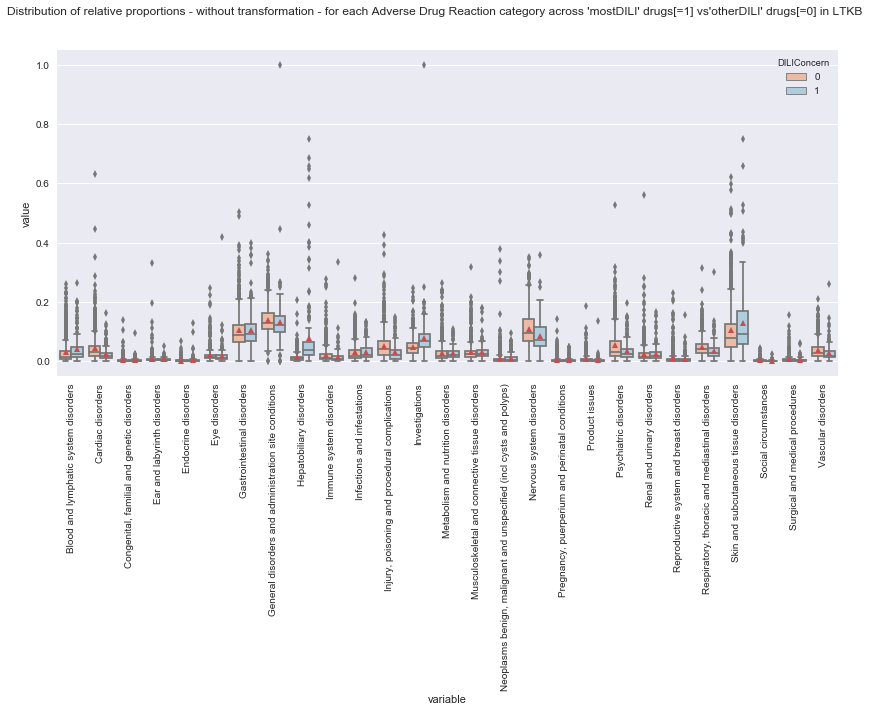

In [22]:
fig, ax = plt.subplots(figsize=(14, 6))
fig.suptitle("Distribution of relative proportions - without transformation - for each Adverse Drug Reaction category across 'mostDILI' drugs[=1] vs'otherDILI' drugs[=0] in LTKB")

ax=sns.boxplot(x = "variable", y="value", data = xy_tidy, palette = "RdBu",showmeans=True, hue="DILIConcern")
plt.xticks(rotation=90)
plt.show();

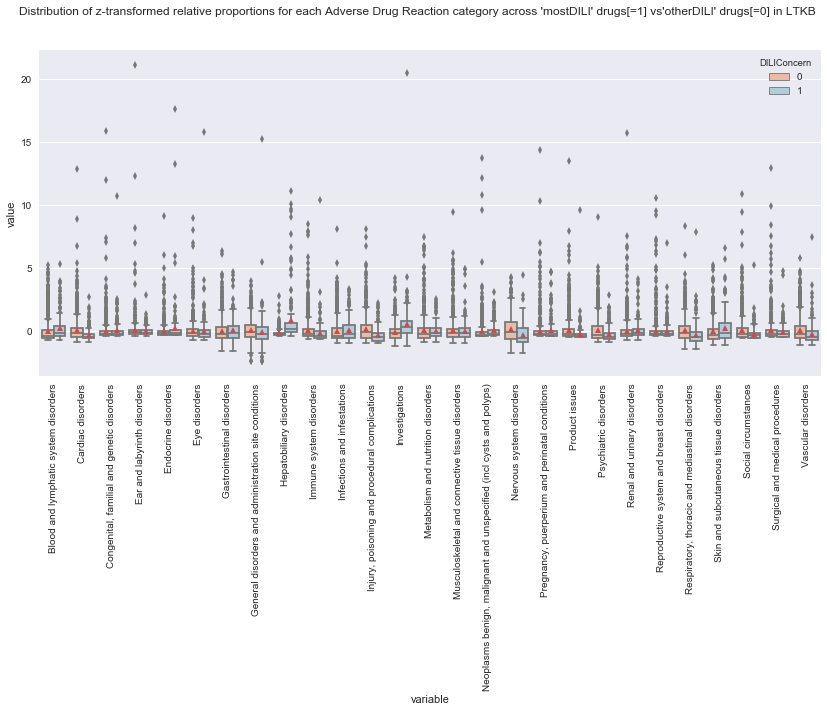

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))
fig.suptitle("Distribution of z-transformed relative proportions for each Adverse Drug Reaction category across 'mostDILI' drugs[=1] vs'otherDILI' drugs[=0] in LTKB")


ax=sns.boxplot(x = "variable", y="value", data = xy_zt_tidy, palette = "RdBu",showmeans=True, hue="DILIConcern")
plt.xticks(rotation=90)
plt.show();

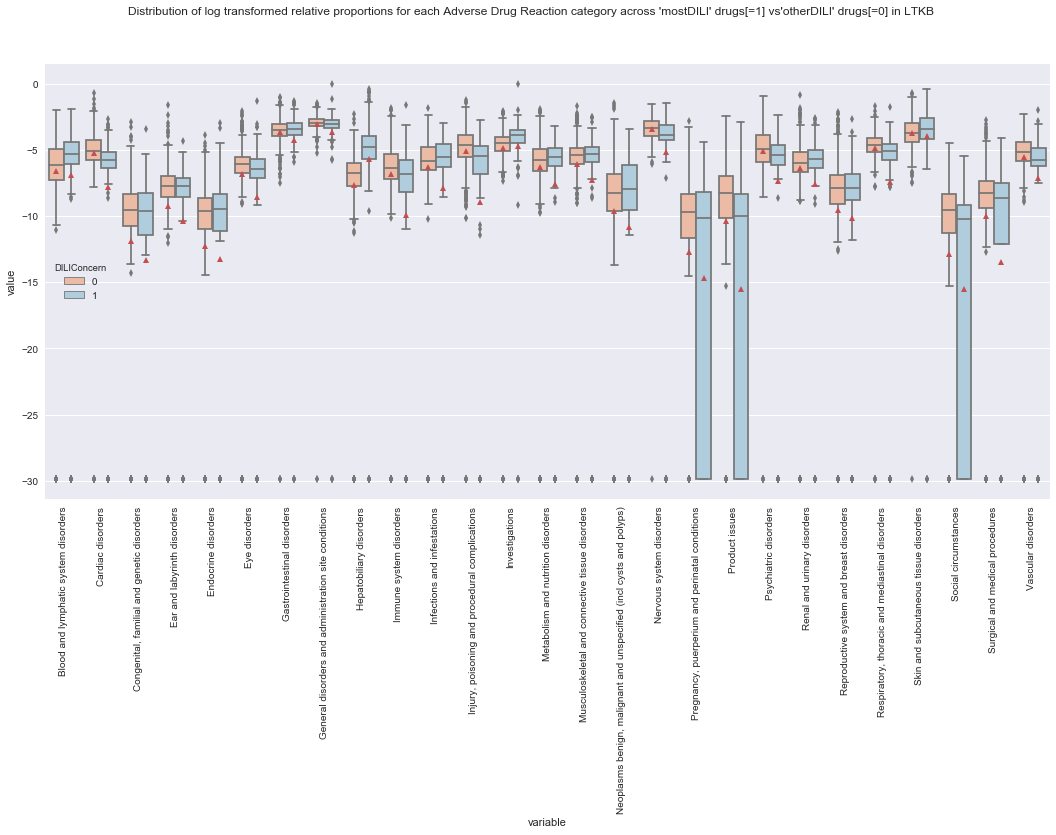

In [24]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle("Distribution of log transformed relative proportions for each Adverse Drug Reaction category across 'mostDILI' drugs[=1] vs'otherDILI' drugs[=0] in LTKB")


ax=sns.boxplot(x = "variable", y="value", data = xy_lt_tidy, palette = "RdBu",showmeans=True, hue="DILIConcern")
plt.xticks(rotation=90)
plt.show();

**Conclusion** - Both untransformed and Z-transformed datasets show right skewed distributions of all predictors - regardless of DILI status. log2 transformation substantially reduced the "right" skew of these distributions.  

Next, each of these predictor sets (without transformation and with Z/log2 transformation) will be evaluated further for effect on ML model performance.

**2. Prepare data for ML**

Goal is to model for "mostDILI" vs "otherDILI". 

In [25]:
#X matrix and Y vector
x=xy.drop(["DILIConcern"], axis=1) # with all predictors
x_lt=xy_lt.drop(["DILIConcern"], axis=1) # with all predictors
x_zt=xy_zt.drop(["DILIConcern"], axis=1) # with all predictors
y=xy_lt.DILIConcern


**3.1 Machine learning - logistic regression - evaluation of feature transformation on model performance**

Evaluating effect of feature transformations on ability to discriminate "mostDILI" vs "otherDILI" drugs. 

To allow for comparison against current benchmark FDA model for DILI predictions (Chen M et al., 2016 Hepatology) and due to its ease of interpretability, logistic regression will be used.   

In [26]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [27]:
#Instantiate multiple logistic regression (to be used for each dataset)
log=LogisticRegression(class_weight='balanced')
    #class_weight = "balanced" used to penalize mistakes on minority (mostDILI) class in proportion to under-representation

In [28]:
#Function to evaluate model performance
def print_accuracy_report(classifier, X, y, num_validations=5):
    auc = cross_val_score(classifier, X, y, scoring='roc_auc', cv=num_validations)
    print ("AUC: " + str(round(100*auc.mean(), 2)) + "%" + " STD: " + str(round(100*auc.std(), 2)) + "%")
    
    recall = cross_val_score(classifier, X, y, scoring='recall', cv=num_validations)
    print ("Recall: " + str(round(100*recall.mean(), 2)) + "%"+ " STD: " + str(round(100*recall.std(), 2)) + "%")

    bal_acc = cross_val_score(classifier, X, y, scoring='balanced_accuracy', cv=num_validations)
    print ("Balanced_Accuracy: " + str(round(100*bal_acc.mean(), 2)) + "%"+ " STD: " + str(round(100*bal_acc.std(), 2)) + "%")

In [29]:
#Print model metrics with DILI concern label (mostDILI vs otherDILI)
print("Model performance with - all 27 real world evidence predictors used as relative proportions and no transformation")
print_accuracy_report(log, x, y)
print("\n")

print("Model performance with - all 27 real world evidence predictors used after Z-transformation")
print_accuracy_report(log, x_zt, y)
print("\n")


print("Model performance with - all 27 real world evidence predictors used after log2-transformation")
print_accuracy_report(log, x_lt, y)
print("\n")

Model performance with - all 27 real world evidence predictors used as relative proportions and no transformation
AUC: 81.3% STD: 2.84%
Recall: 70.69% STD: 5.27%
Balanced_Accuracy: 74.7% STD: 2.33%


Model performance with - all 27 real world evidence predictors used after Z-transformation
AUC: 84.48% STD: 2.51%
Recall: 70.69% STD: 12.55%
Balanced_Accuracy: 76.54% STD: 5.02%


Model performance with - all 27 real world evidence predictors used after log2-transformation
AUC: 86.79% STD: 4.7%
Recall: 77.88% STD: 8.99%
Balanced_Accuracy: 80.06% STD: 3.51%




**Interpretation:** All models perform substantially better than "benchmark" model of Chen M et al 2016 (Hepatology).  Based on the performance of logistic regression, other algorithms will not be evaluated - given the high interpretability of logistic regression.

Best results seen with log2 transformed predictors. log2 transformed predictors will be used for further refinement of logistic regression model via feature selection based on absence of correlation (defined as Pearson's r >0.6) between predictors and step-wise forward feature selection from variable importance (based on odds-ratios). 

These analyses are performed next. 

**3.2 -Feature selection** 

"Best" predictors will be identified from combined
- A. correlation analysis to be done below
- B. odds-ratios of all variables

Step-wise forward feature selection will be used based on odds-ratios and absence of correlation (for discriminating "mostDILI" vs "otherDILI" drugs).

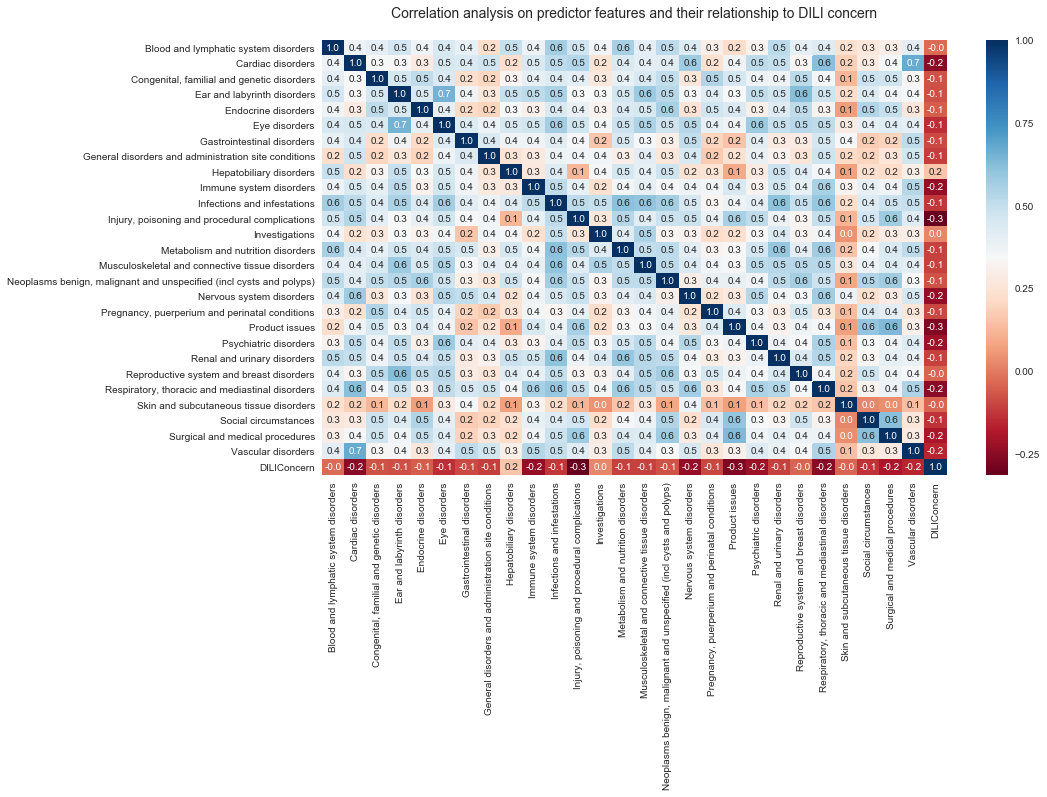

In [30]:
#3.2.A. Correlation analysis

frame3=[x_lt,rwe_xy["DILIConcern"]]

xy_lt=pd.concat(frame3, axis=1)


fig, ax = plt.subplots(figsize=(14,8))

correlation = xy_lt.corr()
sns.heatmap(correlation,cmap="RdBu", annot=True, fmt='0.1f')
plt.title("Correlation analysis on predictor features and their relationship to DILI concern\n", size=14)

plt.show(); # fair # of correlated variables - will do odds-ratios using all predictors and weed out least significant ones

**Interpretation**: Main features that are highly correlated to each other (r>0.6) are cardiac disorders and vascular disorders.

In [31]:
# 3.2.B. Generation of odds ratios for all 27 log2 transformed predictors for variable importance

In [32]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [33]:
train_x_lt, test_x_lt, train_y, test_y = train_test_split(x_lt,y, stratify=y, test_size=0.3, random_state=2)

In [34]:
###Instantiate logistic regression models with each dataset
log2=LogisticRegression(class_weight='balanced')

In [35]:
log2.fit(train_x_lt, train_y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [36]:
### predict test values and probabilities with each dataset
#benchmark predictors alone
log_pred_y=log2.predict(test_x_lt) 
log_probs_y=log2.predict_proba(test_x_lt)  

In [37]:
coeff_x_lt_all = pd.concat([pd.DataFrame(x.columns),pd.DataFrame(np.transpose(log2.coef_))], axis = 1)
coeff_x_lt_all.columns=("features", "coefficients")

coeff_x_lt_all["odds_ratio"]=np.exp(coeff_x_lt_all.coefficients)


coeff_x_lt_all = coeff_x_lt_all.sort_values("odds_ratio", ascending = False)

In [38]:
coeff_x_lt_all

,features,coefficients,odds_ratio
8,Hepatobiliary disorders,1.165421,3.207273
12,Investigations,0.516321,1.675851
26,Vascular disorders,0.405032,1.499350
23,Skin and subcutaneous tissue disorders,0.160694,1.174325
3,Ear and labyrinth disorders,0.144484,1.155443
10,Infections and infestations,0.122085,1.129850
21,Reproductive system and breast disorders,0.087283,1.091206
24,Social circumstances,0.086512,1.090365
15,"Neoplasms benign, malignant and unspecified (i...",0.058475,1.060218
2,"Congenital, familial and genetic disorders",0.055017,1.056558


**Interpretation**: 2-fold change in each of the above predictors results in increase (or decrease) of odds for being a most-DILI drug based on odds-ratios indicated in above table.

As a next step, forward feature selection will be performed based on above odds-ratios for each predictor.

In [39]:
#top 4 predictors
selected_4_cols=['Hepatobiliary disorders','Investigations',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders']

x_lt_lim4=x_lt[selected_4_cols]

In [40]:
#top 5 predictors
selected_5_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders']

x_lt_lim5=x_lt[selected_5_cols]

In [41]:
#top 6 predictors
selected_6_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',#top 6 predictors
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                'Renal and urinary disorders']

x_lt_lim6=x_lt[selected_6_cols]

In [42]:
#top 7 predictors
selected_7_cols=['Hepatobiliary disorders','Investigations','Vascular disorders', 
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders', 'Immune system disorders']

x_lt_lim7=x_lt[selected_7_cols]

In [43]:
#top 8 predictors
selected_8_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders', 'Injury, poisoning and procedural complications',
                 'Immune system disorders']

x_lt_lim8=x_lt[selected_8_cols]

In [44]:
#top 9 predictors
selected_9_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders','Musculoskeletal and connective tissue disorders',
                 'Immune system disorders','Injury, poisoning and procedural complications' ]

x_lt_lim9=x_lt[selected_9_cols]

In [45]:
#top 10 predictors
selected_10_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders','Musculoskeletal and connective tissue disorders',
                 'Immune system disorders','Injury, poisoning and procedural complications' ,
                  'Gastrointestinal disorders']

x_lt_lim10=x_lt[selected_10_cols]

In [46]:
#top 11 predictors
selected_11_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders','Musculoskeletal and connective tissue disorders',
                 'Immune system disorders','Injury, poisoning and procedural complications' ,
                  'Gastrointestinal disorders','Skin and subcutaneous tissue disorders']

x_lt_lim11=x_lt[selected_11_cols]

In [47]:
#top 12 predictors
selected_12_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders','Musculoskeletal and connective tissue disorders',
                 'Immune system disorders','Injury, poisoning and procedural complications' ,
                  'Gastrointestinal disorders','Skin and subcutaneous tissue disorders',
                  'Blood and lymphatic system disorders']

x_lt_lim12=x_lt[selected_12_cols]

In [48]:
#Print model metrics with DILI concern label (mostDILI vs otherDILI) and forward selected predictors
print("Model performance with all 27 log2 transformed real world evidence predictors")
print_accuracy_report(log, x_lt, y)
print("\n")

print("Model performane with top 4 log2 transformed real world evidence predictors")
print_accuracy_report(log, x_lt_lim4, y)
print("\n")

print("Model performane with top 5 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim5, y)
print("\n")

print("Model performane with top 6 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim6, y)
print("\n")

print("Model performane with top 7 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim7, y)
print("\n")

print("Model performane with top 8 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim8, y)
print("\n")

print("Model performane with top 9 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim9, y)
print("\n")

print("Model performane with top 10 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim10, y)
print("\n")

print("Model performane with top 11 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim11, y)
print("\n")

print("Model performane with top 12 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim12, y)
print("\n")

Model performance with all 27 log2 transformed real world evidence predictors
AUC: 86.79% STD: 4.7%
Recall: 77.88% STD: 8.99%
Balanced_Accuracy: 80.06% STD: 3.51%


Model performane with top 4 log2 transformed real world evidence predictors
AUC: 85.82% STD: 1.67%
Recall: 75.14% STD: 5.28%
Balanced_Accuracy: 77.45% STD: 4.0%


Model performane with top 5 log2 transformed real world evidence predictors 
AUC: 85.87% STD: 1.58%
Recall: 75.69% STD: 5.38%
Balanced_Accuracy: 77.73% STD: 3.65%


Model performane with top 6 log2 transformed real world evidence predictors 
AUC: 87.11% STD: 1.12%
Recall: 74.04% STD: 7.55%
Balanced_Accuracy: 77.59% STD: 3.09%


Model performane with top 7 log2 transformed real world evidence predictors 
AUC: 87.23% STD: 1.35%
Recall: 75.14% STD: 8.43%
Balanced_Accuracy: 78.48% STD: 3.58%


Model performane with top 8 log2 transformed real world evidence predictors 
AUC: 87.71% STD: 1.4%
Recall: 77.33% STD: 7.38%
Balanced_Accuracy: 79.64% STD: 3.59%


Model perform

**Interpretation** - Top8 log2 transformed is best predictor set with ~equivalent performance to that of all 27 predictors. Although modest, model performance improves from selection of Top 4 predictors to Top 8 predictors (~3% on average).

As a next step, also evaluate model performance with vs without "hepatobiliary" disorders against model w/top8 predictors.

In [49]:
minushepatobiliary_cols=['Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders', 'Injury, poisoning and procedural complications',
                 'Immune system disorders']

x_lt_lim8_minushb=x_lt[minushepatobiliary_cols]

hbonly=['Hepatobiliary disorders']
x_lt_hbonly=x_lt[hbonly]

print("Model performance with top 8 log2 transformed real world evidence predictors ")
print_accuracy_report(log, x_lt_lim8, y)
print("\n")

print("Effect of removing hepatobiliary disorders on performance of model with 'top8' features")
print_accuracy_report(log, x_lt_lim8_minushb, y)
print("\n")

print("Model performance with only hepatobiliary disorders as an input feature")
print_accuracy_report(log, x_lt_hbonly, y)
print("\n")

Model performance with top 8 log2 transformed real world evidence predictors 
AUC: 87.71% STD: 1.4%
Recall: 77.33% STD: 7.38%
Balanced_Accuracy: 79.64% STD: 3.59%


Effect of removing hepatobiliary disorders on performance of model with 'top8' features
AUC: 78.76% STD: 5.83%
Recall: 64.68% STD: 8.97%
Balanced_Accuracy: 70.8% STD: 5.15%


Model performance with only hepatobiliary disorders as an input feature
AUC: 83.78% STD: 3.92%
Recall: 83.95% STD: 10.48%
Balanced_Accuracy: 73.6% STD: 4.02%




**Note/Justification for final model components (part 1):** 

Based on immediate analysis above, even after removal of hepatobiliary disorders, model peforms fairly well indicating value in retaining remaining 7 predictors. 

The performance of model using only hepatobiliary disorders is impressive - but given that this feature is relatively rare to populate and the additional features have predictive value (and often populate more frequently than hepatobiliary disorders), these features are retained in the final model. This will be potentially useful for DILI classification of newer drugs that may not be populated as heavily for hepatobiliary disorders as they may be for the remaining 7 ADRs/disorders in model.

As a next step, visualize (plot) relative distributions of all 27 ADR features vs top 8 features in ~900 DILI-labeled drugs before moving further to visualize the relative distributions of these 8 features in "most-DILI" drugs vs "other-DILI" drugs. 

In [50]:
#relative proportion in labeled drugs (912 drugs "labeled" for DILI) 
adr_freq_ld=xy_tidy.groupby("variable")["value"].mean().sort_values(ascending=False).reset_index() # use dataset without log2 transformation of ADR percentages
adr_freq_ld.head()

,variable,value
0,General disorders and administration site cond...,0.137699
1,Skin and subcutaneous tissue disorders,0.111253
2,Nervous system disorders,0.104699
3,Gastrointestinal disorders,0.104521
4,Investigations,0.054978


In [51]:
#relative proportions in unlabeled drugs (1300 drugs NOT currently labeled for DILI)
no_label_data=pd.read_csv("adr_1300_drgs_prop.csv")

In [52]:
nld_tidy=no_label_data.melt(id_vars=["drug"], value_vars=['Blood and lymphatic system disorders','Cardiac disorders',
                                                     'Congenital, familial and genetic disorders',
                                                     'Ear and labyrinth disorders','Endocrine disorders',
                                                     'Eye disorders','Gastrointestinal disorders',
                                                     'General disorders and administration site conditions',
                                                     'Hepatobiliary disorders','Immune system disorders',
                                                     'Infections and infestations','Injury, poisoning and procedural complications',
                                                     'Investigations','Metabolism and nutrition disorders',
                                                     'Musculoskeletal and connective tissue disorders',
                                                     'Neoplasms benign, malignant and unspecified (incl cysts and polyps)',
                                                     'Nervous system disorders','Pregnancy, puerperium and perinatal conditions',
                                                     'Product issues','Psychiatric disorders','Renal and urinary disorders',
                                                     'Reproductive system and breast disorders',
                                                     'Respiratory, thoracic and mediastinal disorders','Skin and subcutaneous tissue disorders',
                                                     'Social circumstances','Surgical and medical procedures','Vascular disorders'])

adr_freq_nld=nld_tidy.groupby("variable")["value"].mean().sort_values(ascending=False).reset_index() # use dataset without log2 transformation of ADR percentages


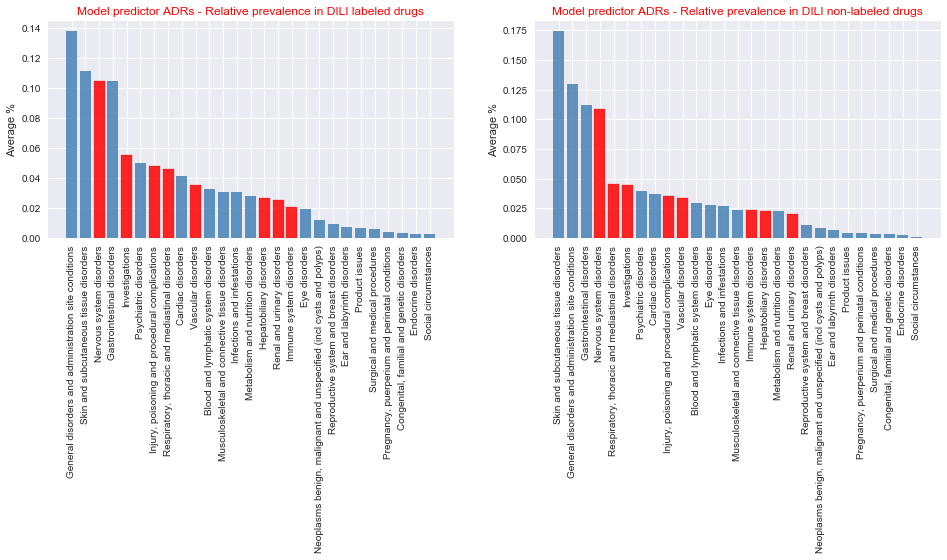

In [53]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)
sns.set(font_scale=1)

axes = fig.add_subplot(121)

plt.title("Model predictor ADRs - Relative prevalence in DILI labeled drugs", color="red")
bp1=plt.bar(adr_freq_ld["variable"],adr_freq_ld["value"], color = 'steelblue', alpha = 0.85)

modelpreds_in_ld=[2,4,6,7,9,14,15,16] #relative ranking/index position of model predictors in sorted list of labeled drugs

for i in modelpreds_in_ld:
    bp1[i].set_color('red')
plt.ylabel('Average %')
plt.xticks(rotation=90)
######
axes = fig.add_subplot(122)

plt.title("Model predictor ADRs - Relative prevalence in DILI non-labeled drugs", color="red")

modelpreds_in_nld=[3,4,5,8,9,14,15,17] # relative ranking/index position of model predictors in sorted list of non-labeled drugs

bp2 = plt.bar(adr_freq_nld.variable,adr_freq_nld.value, color = 'steelblue', alpha = 0.85)

for i in modelpreds_in_nld:
    bp2[i].set_color('red')
plt.ylabel('Average %')
plt.xticks(rotation=90)


plt.show();


**Note/Justification for final model components (part 2):** 
Above analysis justifies inclusion of additional 7 predictors (other than hepatobiliary disorders).

As shown above, regardless of whether or not drug is currently DILI labeled, majority of ADRs used in final model (and indicated in red - above) to model are more frequent/prevalent *on an average* than hepatobiliary disorders. 

*Given that the 7 additional predictors have fair amount of predictive value on their own AND more frequent, they will be retained in final model - especially to enable DILI predictions on drugs that are more recent (and hence might have lower coverage for less frequent predictors such as hepatobiliary disorders).*


In [54]:
#Visualizing relative distribution of top 8 features in most-DILI vs other-DILI drugs
sel_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders','Immune system disorders',
                  'Injury, poisoning and procedural complications', 'DILIConcern']


xy_lt_lim8=xy_lt[sel_cols]
xy_lt_lim8_tidy=xy_lt_lim8.melt(id_vars=["DILIConcern"], value_vars=['Hepatobiliary disorders',
                                                                     'Respiratory, thoracic and mediastinal disorders',
                                                                     'Nervous system disorders',
                                                                     'Injury, poisoning and procedural complications',
                                                                     'Renal and urinary disorders',
                                                                     'Investigations','Vascular disorders',
                                                                     'Immune system disorders',
                                                                     ])

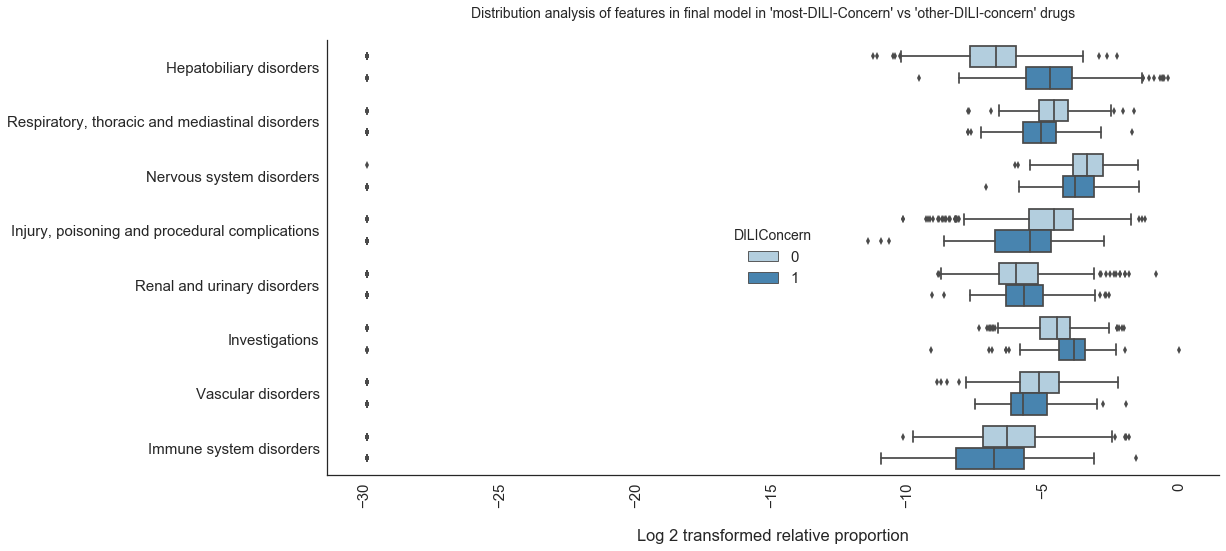

In [55]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)
sns.set(font_scale=1.5)
with sns.axes_style('white'):

    sns.boxplot(x = "value", y="variable", data = xy_lt_lim8_tidy, palette = "Blues", hue="DILIConcern")
    plt.xticks(rotation=90)
    sns.set_style("white")
    sns.despine()
plt.xlabel("\nLog 2 transformed relative proportion")   
plt.ylabel("")
plt.title("Distribution analysis of features in final model in 'most-DILI-Concern' vs 'other-DILI-concern' drugs\n", size=14)
    
   
plt.show();

**3.3 ROC curve for final logistic regression model from sample test-train dataset generated using top 9 log2 transformed features from above**

In [56]:
train_x, test_x, train_y, test_y = train_test_split(x_lt_lim8,y, stratify=y, test_size=0.3, random_state=2)

In [57]:
###Instantiate logistic regression models with each dataset
log_final=LogisticRegression(class_weight='balanced')

In [58]:
log_final.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [59]:
### predict test values and probabilities with each dataset
#benchmark predictors alone
log_final_pred_y=log_final.predict(test_x) 
log_final_probs_y=log_final.predict_proba(test_x)  

In [60]:
#calculate values to populate ROC curves
from sklearn.metrics import roc_curve

log_fpr,log_tpr, log_thresholds=roc_curve(test_y, log_probs_y[:, 1])#retrieve probability of being 1(in second column of probs_y for binary classifier)
log_roc_auc=metrics.auc(log_fpr, log_tpr)

from sklearn.metrics import precision_recall_curve

log_precision, log_recall, log_thresholds = precision_recall_curve(test_y, log_probs_y[:, 1]) #retrieve probability of being 1(in second column of probs_y)
log_pr_auc = metrics.auc(log_recall, log_precision)

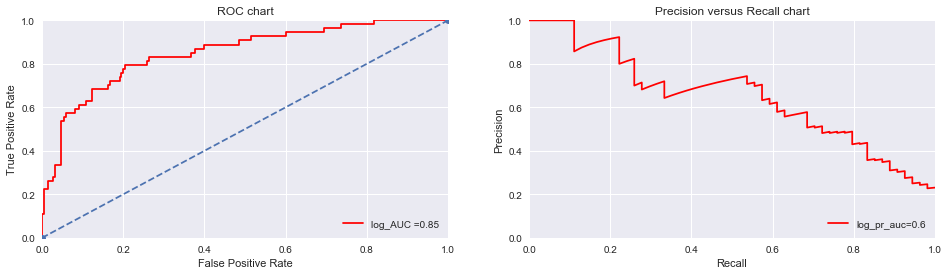

In [61]:
#Plot ROC chart and precision-recall chart
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)
sns.set(font_scale=1)
axes = fig.add_subplot(121)

plt.title("ROC chart")
plt.plot(log_fpr, log_tpr, 'r', label='log_AUC =%0.2f'% log_roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'o--')
plt.axis([0,1, 0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")


axes = fig.add_subplot(122)
plt.title("Precision versus Recall chart")
plt.plot(log_recall, log_precision, "r", label = 'log_pr_auc=%.1f' % (log_pr_auc))
plt.legend(loc='lower right')
plt.axis([0,1, 0,1])
plt.ylabel("Precision")
plt.xlabel("Recall")

plt.show();

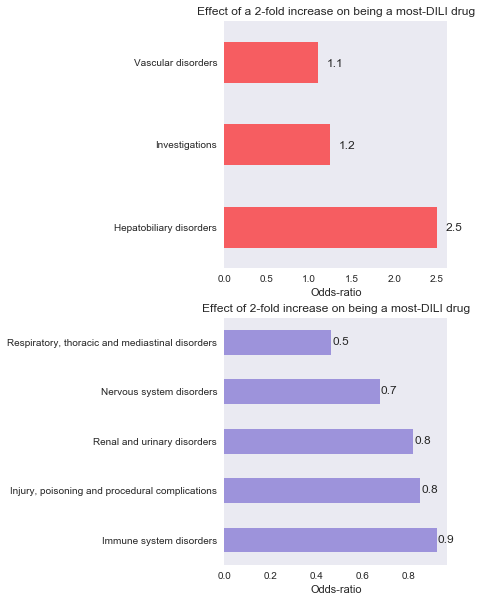

In [62]:
###Construct a dataframe of all features with their coefficients/odds-ratios from "final" model
coeff_final = pd.concat([pd.DataFrame(x_lt_lim8.columns),pd.DataFrame(np.transpose(log_final.coef_))], axis = 1)
coeff_final.columns=("features", "coefficients")
coeff_final["odds_ratio"]=np.exp(coeff_final.coefficients)
coeff_final.head(9)

#Sort dataframe by odds-ratios and plot
coeff_final.sort_values("odds_ratio", ascending=False)

coeff_pos=coeff_final[coeff_final["odds_ratio"]>1] #Generate dataframe of "positive" predictors 
coeff_pos_=coeff_pos.sort_values("odds_ratio", ascending=True)

coeff_neg=coeff_final[coeff_final["odds_ratio"]<=1]  #Generate dataframe of "negative" predictors of mortality
coeff_neg=coeff_neg.sort_values("odds_ratio", ascending=False)

#plot
fig, (ax1, ax2)=plt.subplots(2,1, figsize=(4,10))
sns.set_style("white")


coeff_pos.plot(x="features", y="odds_ratio", kind="barh", legend=False, ax=ax1,color="red", alpha=0.6)
ax1.set_xlabel("Odds-ratio")
ax1.set_ylabel("")
ax1.set_title("Effect of a 2-fold increase on being a most-DILI drug")
for i in ax1.patches:
    ax1.text(i.get_width()+.1, i.get_y()+.2,str(round((i.get_width()), 1)), fontsize=12)# attach values next to each bar in bar chart


coeff_neg.plot(x="features", y="odds_ratio", kind="barh", legend=False, ax=ax2, color="slateblue", alpha=0.6)
ax2.set_xlabel("Odds-ratio")
ax2.set_ylabel("")
ax2.set_title("Effect of 2-fold increase on being a most-DILI drug")
for i in ax2.patches:
    ax2.text(i.get_width()+.005, i.get_y()+.2,str(round((i.get_width()), 1)), fontsize=12) # attach values next to each bar in bar chart

sns.despine()
plt.show();

**4. Predictions on 1300 drugs based on best logistic regression model (w/ top 9 predictors log2 transformed)**

Best model based on 8 selected log2 transformed predictors will be used to "predict" DILI labels on list of 1300 drugs without DILI predictions currently.The ADR list for 1300 drugs will be log2 transformed identically and same top9 features used for predictions.

In [63]:
no_label_data=pd.read_csv("adr_1300_drgs_prop.csv")

In [64]:
no_label_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 28 columns):
drug                                                                   1300 non-null object
Blood and lymphatic system disorders                                   1300 non-null float64
Cardiac disorders                                                      1300 non-null float64
Congenital, familial and genetic disorders                             1300 non-null float64
Ear and labyrinth disorders                                            1300 non-null float64
Endocrine disorders                                                    1300 non-null float64
Eye disorders                                                          1300 non-null float64
Gastrointestinal disorders                                             1300 non-null float64
General disorders and administration site conditions                   1300 non-null float64
Hepatobiliary disorders                                  

In [65]:
numerics=[ 'Blood and lymphatic system disorders','Cardiac disorders','Congenital, familial and genetic disorders',
              'Ear and labyrinth disorders','Endocrine disorders','Eye disorders','Gastrointestinal disorders',
              'General disorders and administration site conditions','Hepatobiliary disorders','Immune system disorders',
              'Infections and infestations','Injury, poisoning and procedural complications','Investigations',
              'Metabolism and nutrition disorders','Musculoskeletal and connective tissue disorders',
              'Neoplasms benign, malignant and unspecified (incl cysts and polyps)','Nervous system disorders',
              'Pregnancy, puerperium and perinatal conditions','Product issues','Psychiatric disorders',
              'Renal and urinary disorders','Reproductive system and breast disorders',
              'Respiratory, thoracic and mediastinal disorders','Skin and subcutaneous tissue disorders',
              'Social circumstances','Surgical and medical procedures','Vascular disorders']

nld_x=no_label_data[numerics]

In [66]:
nld_x.head()

,Blood and lymphatic system disorders,Cardiac disorders,"Congenital, familial and genetic disorders",Ear and labyrinth disorders,Endocrine disorders,Eye disorders,Gastrointestinal disorders,General disorders and administration site conditions,Hepatobiliary disorders,Immune system disorders,...,"Pregnancy, puerperium and perinatal conditions",Product issues,Psychiatric disorders,Renal and urinary disorders,Reproductive system and breast disorders,"Respiratory, thoracic and mediastinal disorders",Skin and subcutaneous tissue disorders,Social circumstances,Surgical and medical procedures,Vascular disorders
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.034682,0.011561,0.000000,0.001445,0.000000,0.010597,0.278420,0.170039,0.005780,0.002890,...,0.000000,0.000963,0.015414,0.027938,0.001445,0.038536,0.038054,0.000963,0.018304,0.019268
3,0.016624,0.033934,0.000916,0.003174,0.005007,0.007166,0.070650,0.228574,0.021172,0.001505,...,0.000556,0.006250,0.019732,0.024543,0.003600,0.033967,0.025263,0.002356,0.039759,0.039890
4,0.000000,0.009524,0.009524,0.009524,0.000000,0.428571,0.019048,0.076190,0.000000,0.019048,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.038095,0.009524,0.000000,0.000000,0.028571


In [67]:
nld_x_zero_adj=nld_x.replace(0, 0.000000001) #add a tiny fraction to enable log2 transformation

In [68]:
#log2 transform all numeric features
nld_x_zero_adj_lt = nld_x_zero_adj.apply(lambda x: np.log2(x) if np.issubdtype(x.dtype, np.number) else x)  

In [69]:
selected_8_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders','Immune system disorders','Injury, poisoning and procedural complications']

nld_test8_x=nld_x_zero_adj_lt[selected_8_cols] #inputted as "test" data for generating predictions from "final" model (using 9 predictors selected from above)

In [70]:
nld_test8_x.info() #check dataframe properties

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 8 columns):
Hepatobiliary disorders                            1300 non-null float64
Investigations                                     1300 non-null float64
Vascular disorders                                 1300 non-null float64
Respiratory, thoracic and mediastinal disorders    1300 non-null float64
Nervous system disorders                           1300 non-null float64
Renal and urinary disorders                        1300 non-null float64
Immune system disorders                            1300 non-null float64
Injury, poisoning and procedural complications     1300 non-null float64
dtypes: float64(8)
memory usage: 81.3 KB


In [71]:
#Instantiate multiple logistic regression with class weight "balancing"
log_final_pred=LogisticRegression(class_weight='balanced')
    #class_weight = "balanced" used to penalize mistakes on minority (mostDILI) class in proportion to under-representation

In [72]:
#fit training data
log_final_pred.fit(x_lt_lim8,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [73]:
#generate DILI predictions on "not-labeled data"
log_pred_y=log_final_pred.predict(nld_test8_x)
log_probs_y=log_final_pred.predict_proba(nld_test8_x)

In [74]:
DILI_1300preds_final=pd.concat([pd.DataFrame(log_pred_y),pd.DataFrame(log_probs_y[:,1])], axis = 1)
DILI_1300preds_final.columns = ["Pred_Class_label", "Class1_prob"]

In [75]:
DILI_1300preds_final.head()

,Pred_Class_label,Class1_prob
0,1,9.995097e-01
1,1,9.995097e-01
2,0,3.046482e-01
3,1,7.871177e-01
4,0,6.291274e-10


In [76]:
frames=[no_label_data.drug, DILI_1300preds_final]
DILI_1300preds_final = pd.concat(frames, axis=1)

In [77]:
DILI_1300preds_final.head()

,drug,Pred_Class_label,Class1_prob
0,1-hexadecanol,1,9.995097e-01
1,7-keto-DHEA,1,9.995097e-01
2,abemaciclib,0,3.046482e-01
3,abiraterone,1,7.871177e-01
4,aceclidine,0,6.291274e-10


In [78]:
DILI_1300preds_final.to_csv("DILI_finalpreds_1300_drgs.csv", index=False)

**Next steps:** Above set of 1300 drugs with predicted DILI labels will be combined with 912 drugs from LTKB with FDA labels to generate a "masterkist" of 2212 drugs. This masterlist will then be combined with the remaining 123 drugs in LTKB dataset that are labeled for DILI risk but for whom I could not obtain RWE data from vigiaccess.org (thus, these were omitted for modeling).

This expansion of the "masterlist" is performed in the next step. Following this expansion, we should have a "masterlist" of 2335 drugs that are labeled for their DILI risk (for deploying into an app for "on-demand" generation of DILI labels/risk based on user entry of drug name).

**5. Identify LTKB drugs with DILI labels but without RWE (and not in "masterdataset") for further expansion into "final_masterdata"**

In [79]:
masterdata=pd.read_csv("MasterList_2200Drugs_FinalDILIPreds.csv") #contains either DILI predictions on 1300 drugs or FDA DILI labels on 912 drugs
ltkbdata=pd.read_csv("ltkbdata.csv") #contains DILI predictions for 1035 drugs - including those for which I could not find RWE data on vigiaccess.org

In [80]:
ltkbdata.rename(columns={'LabelCompoundName': 'drug', "DILIConcern": "LTKBDILIConcern"}, inplace=True)

In [81]:
ltkbdata.head()

,LTKBID,PubChem_CID,drug,ApprovalYear,LTKBDILIConcern,SeverityClass,LabelSection,AdjudicatedDILI,vDILIConcern,Greene_Annotation,Sakatis_Annotation,Xu_Annotation,Zhu_Annotation,SMILES,URL (accessed on 1/21/2016),"VER_DISP (1=LTKB-BD, 2=others)"
0,LT01185,5361919.0,ceftriaxone,1984.0,Less-DILI-Concern,4,Adverse reactions,Yes,vLess-DILI-Concern,HH,non-hepatotixic,Positive,Postive,CN1C(=NC(=O)C(=O)N1)SCC2=C(N3[C@@H]([C@@H](C3=...,http://dailymed.nlm.nih.gov/dailymed/drugInfo....,2
1,LT01842,5578.0,trimethoprim,1980.0,Less-DILI-Concern,4,Adverse reactions,Yes,vLess-DILI-Concern,HH,non-hepatotixic,Positive,Postive,COC1=CC(=CC(=C1OC)OC)CC2=CN=C(N=C2N)N,http://dailymed.nlm.nih.gov/dailymed/drugInfo....,2
2,LT00036,5353990.0,tetracycline,1953.0,Less-DILI-Concern,2,Warnings and precautions,Yes,vLess-DILI-Concern,HH,Hepatotoxic,Positive,Postive,CC1(C2CC3C(C(=O)/C(=C(\N)/O)/C(=O)C3(C(=O)C2=C...,http://dailymed.nlm.nih.gov/dailymed/drugInfo....,1
3,LT00289,2955.0,dapsone,1979.0,Less-DILI-Concern,3,Warnings and precautions,Yes,vLess-DILI-Concern,HH,Hepatotoxic,Positive,Postive,C1=CC(=CC=C1N)S(=O)(=O)C2=CC=C(C=C2)N,http://dailymed.nlm.nih.gov/dailymed/drugInfo....,2
4,LT00166,1046.0,pyrazinamide,1971.0,Less-DILI-Concern,3,Warnings and precautions,Yes,vLess-DILI-Concern,HH,Hepatotoxic,Positive,Postive,C1=CN=C(C=N1)C(=O)N,http://dailymed.nlm.nih.gov/dailymed/drugInfo....,1


In [82]:
md_select_cols=["drug", "DILIConcern", "Investigations"]
ltkb_select_cols=["drug", "LTKBID", "LTKBDILIConcern"]

In [83]:
masterdata=masterdata[md_select_cols]
ltkbdata=ltkbdata[ltkb_select_cols]

In [84]:
alldrugs=pd.merge(masterdata, ltkbdata, on="drug", how="outer")

In [85]:
alldrugs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2336 entries, 0 to 2335
Data columns (total 5 columns):
drug               2336 non-null object
DILIConcern        2213 non-null object
Investigations     2213 non-null float64
LTKBID             1042 non-null object
LTKBDILIConcern    1042 non-null object
dtypes: float64(1), object(4)
memory usage: 109.5+ KB


In [86]:
alldrugs.to_csv("alldrugs_2300.csv", index=False) 
# export and append drugs from LTKB with DILIlabel but without RWE to generate a "final" masterlist of all drugs and their DILI label

**6. Compare ADR distributions of top predictors for drugs currently labeled as "most-DILI" drugs vs predicted by model to be "most-DILI"**

If the predicted most-DILI drugs have similar distributions especially for the top predictors, it is more likely that they in-fact turn out to be 'Most-DILI' in future. This concept is presented as a simplistic approach to validation of model predictions - until more evidence-based curation/validation is performed in the real world.

In [87]:
labls_preds=pd.read_csv("DILI_labels_preds_2200_drgs.csv") #import dataset containing predicted DILI labels vs existing (FDA) labels
labls_preds.head()

,drug,Blood and lymphatic system disorders,Cardiac disorders,"Congenital, familial and genetic disorders",Ear and labyrinth disorders,Endocrine disorders,Eye disorders,Gastrointestinal disorders,General disorders and administration site conditions,Hepatobiliary disorders,...,Psychiatric disorders,Renal and urinary disorders,Reproductive system and breast disorders,"Respiratory, thoracic and mediastinal disorders",Skin and subcutaneous tissue disorders,Social circumstances,Surgical and medical procedures,Vascular disorders,RowProportion_Sum,DILIConcern
0,1-hexadecanol,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,predicted_Most-DILI
1,4-aminosalicylic acid,0.028032,0.006865,0.001144,0.018021,0.016876,0.008867,0.382437,0.102403,0.032895,...,0.028604,0.010584,0.000286,0.023455,0.097540,0.001144,0.000572,0.005721,1,Most-DILI
2,7-keto-DHEA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,predicted_Less-DILI-or-No-DILI
3,abacavir,0.027546,0.024868,0.010177,0.004285,0.001913,0.008646,0.112786,0.150126,0.026934,...,0.025480,0.025480,0.007499,0.043615,0.142628,0.001148,0.005356,0.016145,1,Most-DILI
4,abatacept,0.007019,0.014379,0.000860,0.004247,0.001557,0.012399,0.058118,0.239697,0.005517,...,0.013505,0.008289,0.003837,0.052711,0.053175,0.002745,0.026533,0.018858,1,Less-DILI-or-No-DILI


In [88]:
#Limit analysis to top predictors within final model
selected_cols=['Hepatobiliary disorders','Investigations','Vascular disorders',
                 'Respiratory, thoracic and mediastinal disorders','Nervous system disorders',
                 'Renal and urinary disorders', 'Injury, poisoning and procedural complications',
                 'Immune system disorders', 'DILIConcern']

lim_labls_preds=labls_preds[selected_cols]

#Subset data (for subsequent visual analyses)
FDA_mostDILI = lim_labls_preds.loc[lim_labls_preds['DILIConcern'] == "Most-DILI"]
PRED_mostDILI = lim_labls_preds.loc[lim_labls_preds['DILIConcern'] == "predicted_Most-DILI"]

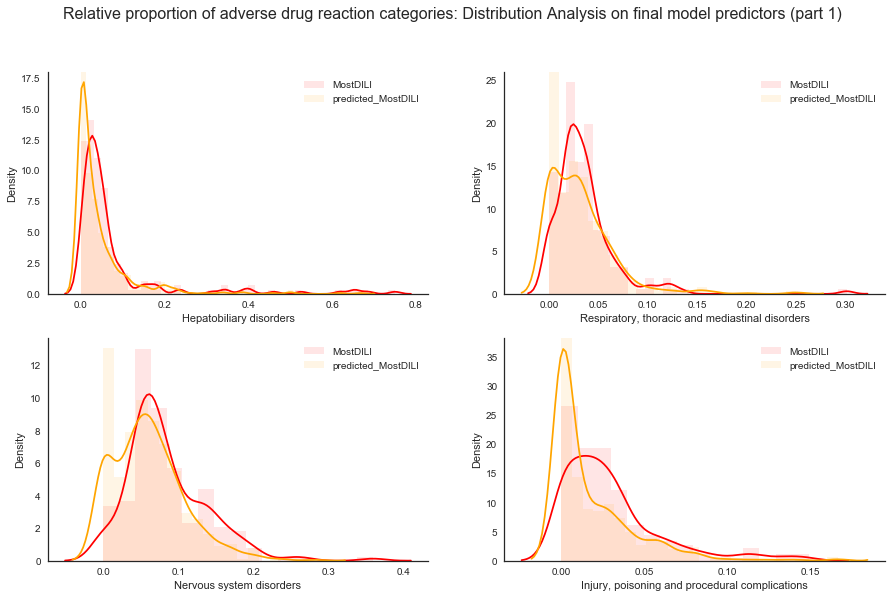

In [89]:
#Generate distribution plots for top4 predictors (of the 8 predictors used in final model)
fig, ax_array = plt.subplots(2,2, figsize=(15,9))
(ax1, ax2), (ax3, ax4) = ax_array

fig.suptitle("Relative proportion of adverse drug reaction categories: Distribution Analysis on final model predictors (part 1)", size=16)

sns.distplot(FDA_mostDILI['Hepatobiliary disorders'], color="red", label="MostDILI", hist=True, hist_kws={"alpha": 0.1},ax=ax1)
sns.distplot(PRED_mostDILI['Hepatobiliary disorders'], color="orange", label="predicted_MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax1)
ax1.set_ylabel("Density")
ax1.legend()

sns.distplot(FDA_mostDILI['Respiratory, thoracic and mediastinal disorders'], color="red", label="MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax2)
sns.distplot(PRED_mostDILI['Respiratory, thoracic and mediastinal disorders'], color="orange", label="predicted_MostDILI", hist=True, hist_kws={"alpha": 0.1},ax=ax2)
ax2.set_ylabel("Density")
ax2.legend()

sns.distplot(FDA_mostDILI['Nervous system disorders'], color="red", label="MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax3)
sns.distplot(PRED_mostDILI['Nervous system disorders'], color="orange", label="predicted_MostDILI",hist_kws={"alpha": 0.1}, hist=True, ax=ax3)
ax3.set_ylabel("Density")
ax3.legend()

sns.distplot(FDA_mostDILI['Injury, poisoning and procedural complications'], color="red", label="MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax4)
sns.distplot(PRED_mostDILI['Injury, poisoning and procedural complications'], color="orange", label="predicted_MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax4)
ax4.set_ylabel("Density")
ax4.legend()

sns.despine()
plt.show();

**Note:** Generally similar distribution for top 4 predictors between drugs currently labeled as "most-DILI" by FDA/LTKB vs predicted to be most-DILI by model. Given overlap between the distributions, predicted "mostDILI" drugs are also likely to be in-fact "most-DILI" drugs.

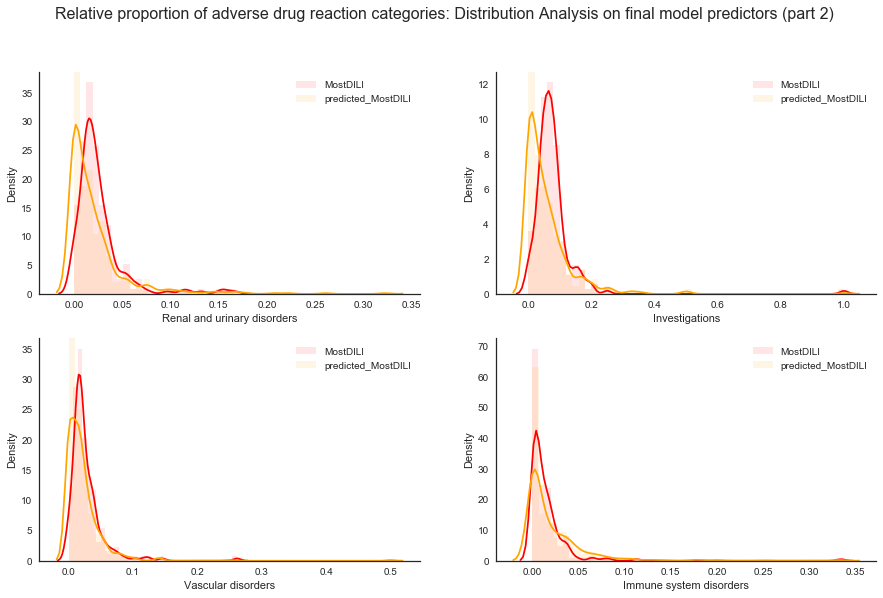

In [90]:
#Generate distribution plots for bottom 4 predictors (of the 8 predictors used in final model)
fig, ax_array = plt.subplots(2,2, figsize=(15,9))
(ax1, ax2), (ax3, ax4) = ax_array

fig.suptitle("Relative proportion of adverse drug reaction categories: Distribution Analysis on final model predictors (part 2)", size=16)

sns.distplot(FDA_mostDILI['Renal and urinary disorders'], color="red", label="MostDILI", hist=True, hist_kws={"alpha": 0.1},ax=ax1)
sns.distplot(PRED_mostDILI['Renal and urinary disorders'], color="orange", label="predicted_MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax1)
ax1.set_ylabel("Density")
ax1.legend()

sns.distplot(FDA_mostDILI['Investigations'], color="red", label="MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax2)
sns.distplot(PRED_mostDILI['Investigations'], color="orange", label="predicted_MostDILI", hist=True, hist_kws={"alpha": 0.1},ax=ax2)
ax2.set_ylabel("Density")
ax2.legend()

sns.distplot(FDA_mostDILI['Vascular disorders'], color="red", label="MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax3)
sns.distplot(PRED_mostDILI['Vascular disorders'], color="orange", label="predicted_MostDILI",hist_kws={"alpha": 0.1}, hist=True, ax=ax3)
ax3.set_ylabel("Density")
ax3.legend()

sns.distplot(FDA_mostDILI['Immune system disorders'], color="red", label="MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax4)
sns.distplot(PRED_mostDILI['Immune system disorders'], color="orange", label="predicted_MostDILI", hist=True,hist_kws={"alpha": 0.1}, ax=ax4)
ax4.set_ylabel("Density")
ax4.legend()

sns.despine()
plt.legend()
plt.show();

**Note:** Generally similar distribution for top 4 and bottom 4 (i.e., all 8 predictors used in "final" model) between drugs currently labeled as "most-DILI" by FDA/LTKB vs predicted to be most-DILI by "final" model. Given excellent overlap between the distributions, predicted "mostDILI" drugs are also likely to be in-fact "most-DILI" drugs.

##############------------------------------THE END------------------------------------###########################